In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"
snapshotPath = "snapshots/"

In [3]:
with open("hyperParams.json") as f:
    instanceParams = json.load(f)

instanceParams

{u'baseLR': 1e-05,
 u'batchSize': 2,
 u'borderThicknessH': 0.02,
 u'borderThicknessW': 0.02,
 u'boundaryAlpha': 6.5,
 u'dataset': u'kitti2012',
 u'flowScale': 20.0,
 u'gradParams': {u'robustness': 0.46, u'scale': 255.0, u'weight': 6.408},
 u'instanceName': u'unsupFlownet',
 u'iterations': 500000,
 u'lossComponents': {u'asymmetricSmooth': True,
  u'backward': False,
  u'boundaries': False,
  u'gradient': False,
  u'smooth2nd': False},
 u'photoParams': {u'robustness': 0.53, u'scale': 360.0},
 u'printFreq': 1000,
 u'resnet': False,
 u'smooth2ndParams': {u'robustness': 0.21, u'scale': 1.0, u'weight': 0.53},
 u'smoothOccParams': {u'robustness': 0.9, u'scale': 1.8},
 u'smoothParams': {u'robustness': 1, u'scale': 3.5, u'weight': 0.4},
 u'snapFreq': 5000,
 u'snapshotFreq': 20000,
 u'weightDecay': 0.0}

In [4]:
printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

from dotmap import DotMap
arg = DotMap()
arg.logDev = False
arg.resume = 'y'
resume, startIteration, snapshotFiles = checkResume(snapshotPath,logPath, arg)
iterations = 1000 * 20

resuming from iteration 501000


In [5]:
gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/swing/00043.png")
# gt[200:300, 300:400] = 1

# x0 = 300
# y0 = 200
# for x in range(x0, x0 + 50):
#     for y in range(y0, y0 + 50):
#         if y > x - 100:
#             gt[y,x] = 0
# x0 = 300
# y0 = 250
# for x in range(x0, x0 + 50):
#     for y in range(y0, y0 + 50):
#         if y <= 600 - x:
#             gt[y,x] = 0

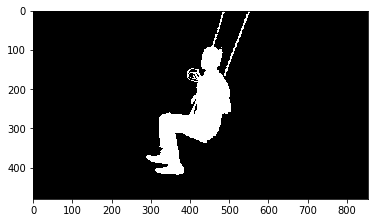

In [6]:
plt.imshow(gt, cmap='gray')

In [7]:
flow = np.zeros((480, 854, 2))

# mask = np.zeros((480, 854))
# mask[200:300, 300:400] = 1

# x0 = 300
# y0 = 200
# for x in range(x0, x0 + 25):
#     for y in range(y0, y0 + 50):
#         if y > 2 * x - 400:
#             mask[y,x] = 0
# x0 = 300
# y0 = 250
# for x in range(x0, x0 + 25):
#     for y in range(y0, y0 + 50):
#         if y <= 900 - 2 * x:
#             mask[y,x] = 0

In [8]:
# flow[mask == 0, :] = np.array([1,1])
# flow[mask != 0, :] = -np.array([1,1])

flow[0:300,:,:] = np.array([1,1])
flow[300:480,:,:] = -np.array([1,1])

flow = np.load("flow1.npy")[0]

max flow: 35.5493
flow range:
u = -23.369 .. 35.544
v = -19.271 .. 2.092


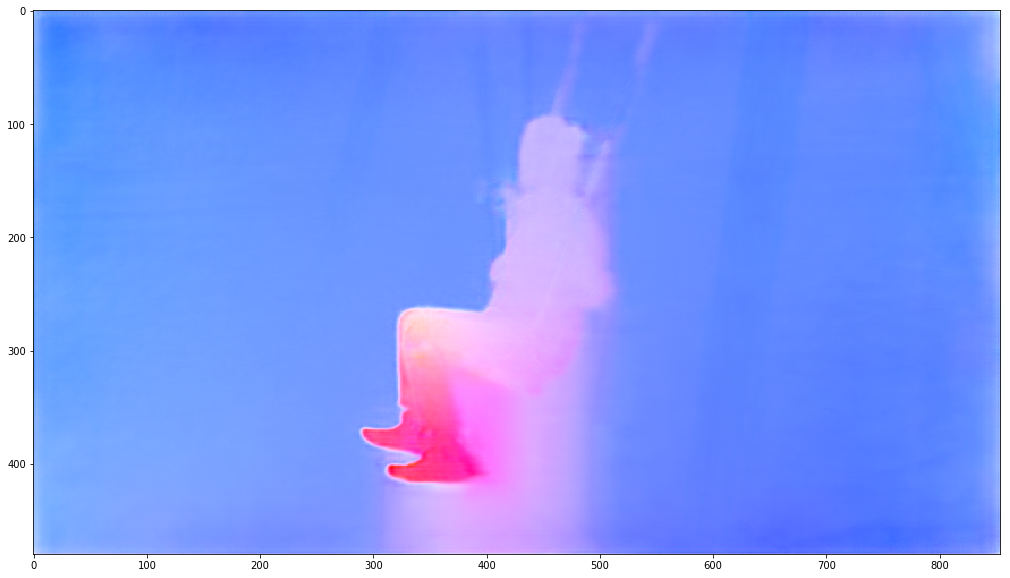

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(flow_to_image(flow))

In [10]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [11]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [12]:
kernel = tf.transpose(tf.constant([
    [
        [
            [0,-1,0],
            [0,1,0],
            [0,0,0]
        ]
    ], [
        [
            [0,0,0],
            [0,1,-1],
            [0,0,0]
        ]
    ], [
        [
            [0,0,0],
            [0,1,0],
            [0,-1,0]
        ]
    ], [
        [
            [0,0,0],
            [-1,1,0],
            [0,0,0]
        ]
    ],
],dtype=tf.float32),perm=[3,2,1,0])

In [13]:
# w = 25
w = 1

In [14]:
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

In [15]:
normalizer = tf.zeros((1, 480, 854, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:854,0],
                           tf.zeros((1, 480, j), dtype=tf.float32)], axis=2),
                axis=-1),
            (1, 1, 1, 2))
    )

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 854), dtype=tf.float32),
                           gt_mask[:,0:(480-j),:,1]], axis=1),
                axis=-1),
            (1, 1, 1, 2))
    )

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 480, j), dtype=tf.float32),
                           gt_mask[:,:,0:(854-j),2]], axis=2),
                axis=-1),
            (1, 1, 1, 2))
    )

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:480,:,3],
                           tf.zeros((1, j, 854), dtype=tf.float32)], axis=1),
                axis=-1),
            (1, 1, 1, 2))
    )

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

In [16]:
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
def fixed_point_update(flow):
    temp = tf.zeros_like(flow)

    for i in range(w):
        j = i + 1
        temp += tf.concat([flow[:,:,j:854,:],
                           tf.zeros((1, 480, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

        temp += tf.concat([tf.zeros((1, j, 854, 2), dtype=tf.float32),
                           flow[:,0:(480-j),:,:]], axis=1) * multiplier_masks[i][1]

        temp += tf.concat([tf.zeros((1, 480, j, 2), dtype=tf.float32),
                           flow[:,:,0:(854-j),:]], axis=2) * multiplier_masks[i][2]

        temp += tf.concat([flow[:,j:480,:,:],
                           tf.zeros((1, j, 854, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

    return temp / normalizer

new_flow = flow.assign(fixed_point_update(flow))
new_flow.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

In [19]:
init = tf.global_variables_initializer()
losses = []
flows = []
start_time = None
itr = 20000
print_freq = 200
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        #[l, f] = sess.run([sLoss, new_flow])
        [f] = sess.run([new_flow])
        if i % print_freq == 1:
            if i == print_freq + 1:
                start_time = datetime.now()
            print(i)
            losses.append(deepcopy(np.sum(l)))
            flows.append(deepcopy(f[0]))
            print losses[-1]
print(str(datetime.now() - start_time))

1
39199444.0
201
39199444.0
401
39199444.0
601
39199444.0
801
39199444.0
1001
39199444.0
1201
39199444.0
1401
39199444.0
1601
39199444.0
1801
39199444.0
2001
39199444.0
2201
39199444.0
2401
39199444.0
2601
39199444.0
2801
39199444.0
3001
39199444.0
3201
39199444.0
3401
39199444.0
3601
39199444.0
3801
39199444.0
4001
39199444.0
4201
39199444.0
4401
39199444.0
4601
39199444.0
4801
39199444.0
5001
39199444.0
5201
39199444.0
5401
39199444.0
5601
39199444.0
5801
39199444.0
6001
39199444.0
6201
39199444.0
6401
39199444.0
6601
39199444.0
6801
39199444.0
7001
39199444.0
7201
39199444.0
7401
39199444.0
7601
39199444.0
7801
39199444.0
8001
39199444.0
8201
39199444.0
8401
39199444.0
8601
39199444.0
8801
39199444.0
9001
39199444.0
9201
39199444.0
9401
39199444.0
9601
39199444.0
9801
39199444.0
10001
39199444.0
10201
39199444.0
10401
39199444.0
10601
39199444.0
10801
39199444.0
11001
39199444.0
11201
39199444.0
11401
39199444.0
11601
39199444.0
11801
39199444.0
12001
39199444.0
12201
39199444.0
124

In [21]:
plt.plot(np.log(losses))
np.log(losses)

max flow: 22.8476
flow range:
u = -18.772 .. 19.927
v = -15.763 .. -0.000


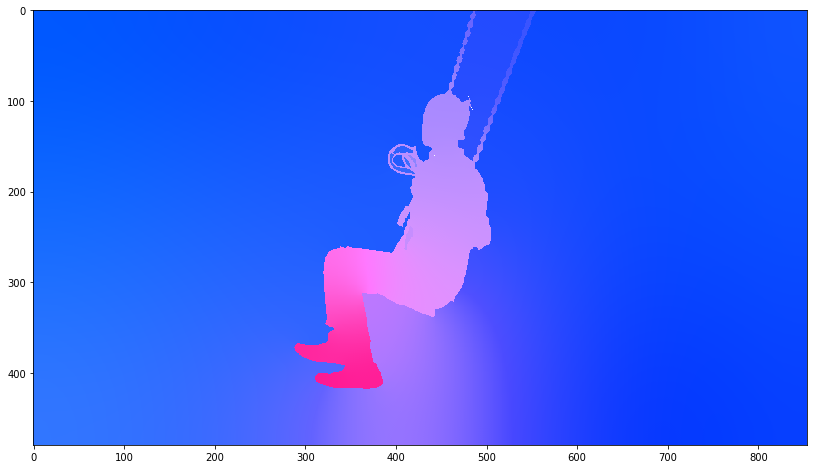

In [22]:
plt.figure(figsize=(15, 8))
plt.imshow(flow_to_image(flows[-1]))

### Training

In [ ]:
plt.imshow(flow_to_image(flows[100]))

In [ ]:
plt.imshow(flow_to_image(flows[30]))

In [ ]:
with tf.device("/gpu:0"):
    trainingData = TrainingData(batchSize,instanceParams)

with tf.device("/gpu:0"):
    # init
    with tf.variable_scope("netShare"):
        networkBodyF = NetworkBody(trainingData,instanceParams)
    with tf.variable_scope("netShare",reuse=True):
        networkBodyB = NetworkBody(trainingData,instanceParams,flipInput=True)

    trainingLoss = TrainingLoss(instanceParams,networkBodyF,networkBodyB,trainingData)
    solver,learningRateTensor = attachSolver(trainingLoss.loss)

    # loss scheduling
    recLossBWeightTensor = trainingLoss.recLossBWeight

In [ ]:
# merge summaries
merged = tf.summary.merge_all()
# saver
saver = tf.train.Saver(max_to_keep=0)

In [ ]:
printFrequency = 36
snapshotFrequency = 2000
iterations = 10000
print(printFrequency)
print(snapshotFrequency)
print(iterations)
print(startIteration)

In [ ]:
# start
with sessionSetup(arg) as sess:
#     if resume:
#         saver.restore(sess,snapshotPath+snapshotFiles[-1][:-6])
#     else:
#         sess.run(tf.initialize_all_variables())
    saver.restore(sess,
                  './snapshots/iter_0000000000510000.ckpt')

    trainingData.dataQueuer.start_queueing(sess)

    #start summary writer
    summary_writer = tf.summary.FileWriter(logPath, sess.graph)

    #run
    lastPrint = time.time()
    for i in range(startIteration, startIteration + iterations + 10):
        # scheduled values
        learningRate = learningRateSchedule(baseLearningRate, i)
        recLossBWeight = unsupLossBSchedule(i)

         #run training
        feed_dict = {
            learningRateTensor: learningRate,
            recLossBWeightTensor: recLossBWeight,
        }
        summary,result,totalLoss = sess.run([merged,solver,trainingLoss.loss], feed_dict=feed_dict)

        if (i+1) % printFrequency == 0:
            timeDiff = time.time() - lastPrint
            itPerSec = printFrequency/timeDiff
            remainingIt = startIteration + iterations + 10 - i
            eta = remainingIt/itPerSec
            print("Iteration "+str(i+1)+": loss: "+str(totalLoss)+", iterations per second: "+str(itPerSec)+", ETA: "+str(datetime.timedelta(seconds=eta)))+", lr: "+str(learningRate)

            summary_writer.add_summary(summary,i+1)
            summary_writer.flush()
            lastPrint = time.time()

        if (i+1) % snapshotFrequency == 0:
            saver.save(sess,"snapshots/iter_"+str(i+1).zfill(16)+".ckpt")

        sys.stdout.flush()

    #close queing
    trainingData.dataQueuer.close(sess)

### Testing

In [ ]:
datasetRoot = '../example_data/'
frame0Path = '../example_data/datalists/swing_im0.txt'
frame1Path = '../example_data/datalists/swing_im1.txt'
gt0Path = '../example_data/datalists/swing_gt0.txt'
desiredHeight = 480
desiredWidth = 854

In [ ]:
with open(frame0Path) as f:
    imagePairs0 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(frame1Path) as f:
    imagePairs1 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(gt0Path) as f:
    gtPairs1 = [datasetRoot+x[:-1] for x in f.readlines()]

In [ ]:
testData = TestData(imagePairs0,imagePairs1,gtPairs1,1,desiredHeight,desiredWidth)

In [ ]:
with tf.device("/gpu:0"):
    with tf.variable_scope("netShare"):
        networkBody = NetworkBody(testData,instanceParams)
    flowFinal = networkBody.flows[0]
    gt = testData.frame0["gt"]
    sLoss = asymmetricSmoothLoss(flowFinal, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    sGrad = tf.gradients(sLoss, flowFinal)[0]

In [ ]:
flowViz = flowToRgb(flowFinal)
transformGrid = flowTransformGrid(flowFinal)
mean = tf.expand_dims(tf.expand_dims(tf.expand_dims([0.407871, 0.457525, 0.481094], 0), 0), 0)

In [ ]:
saver = tf.train.Saver()

# config tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
iterations = 510000

In [ ]:
test_length = 70
start = 0

flows = []
viz = []
gradients = []
ground_truths = []
with tf.Session(config=config) as sess:
    saver.restore(sess,"snapshots_swing/iter_"+str(iterations).zfill(16)+".ckpt")

    # run
    lastPrint = time.time()
    for i in range(start, start + test_length):
        feed_dict = {
            testData.im0File: imagePairs0[i],
            testData.im1File: imagePairs1[i],
            testData.gt0File: gtPairs1[i]
        }
        hsv, f, g, t = sess.run([flowViz, flowFinal, sGrad, gt],feed_dict=feed_dict)

        gradients.append(deepcopy(g))
        ground_truths.append(deepcopy(t))
        flows.append(deepcopy(f))
        h, w = 480, 854
        arr = np.maximum(np.minimum(np.asarray(hsv),1), 0)
        arr = np.squeeze(np.asarray(arr*255,np.uint8))
        im = Image.fromarray(arr[:h,:w,:])
        viz.append(deepcopy(im))
        # im.save("{}/{}.png".format(result_dir, str(i).zfill(3)))

In [ ]:
def plot_smooth_grad(i, overlay=True, sparsity=32):
    # optical flow hsv
    plt.figure(frameon=False, figsize=(15,10))
    plt.imshow(viz[i])

    # segmentation mask
    if overlay:
        plt.imshow(np.reshape(ground_truths[i][0], (480, 854)), cmap='gray', alpha=0.1)

    # optical flow vector field
    X, Y = np.mgrid[0:854, 0:480]
    est = flows[i][0]
    est = np.transpose(est, (1, 0, 2))
    U, V = est[:,:,0], est[:,:,1]
    plt.quiver(X[::sparsity, ::sparsity],
               Y[::sparsity, ::sparsity],
               U[::sparsity, ::sparsity],
               V[::sparsity, ::sparsity],
               color='black',
               edgecolor='k', alpha=0.8,scale_units='xy', scale=1)

    # gradient vector field
    sgrad = np.transpose(gradients[0][0], (1, 0, 2))
    U, V = sgrad[:,:,0], sgrad[:,:,1]
    plt.quiver(X[::sparsity, ::sparsity],
               Y[::sparsity, ::sparsity],
               U[::sparsity, ::sparsity],
               V[::sparsity, ::sparsity],
               color='yellow',
               edgecolor='k', alpha=0.8,angles='xy',scale_units='xy', scale=500)
    plt.axis('off')

In [ ]:
plot_smooth_grad(40, False, sparsity=32)